# Parametric shape optimization with differentiable FEM simulation


## Setup

In [ ]:
# Install additional requirements for this notebook
%pip install -r requirements_os.txt -q --isolated

In [37]:
import tesseract_core

tesseract_core.build_tesseract("sdf_fd", "latest")
tesseract_core.build_tesseract("bars_3d", "latest")
tesseract_core.build_tesseract("hex_mesh", "latest")
tesseract_core.build_tesseract("jax_fem", "latest")
print("Tesseract built successfully.")

Tesseract built successfully.


## Design Space Tesseract

In [38]:
import imageio
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from tesseract_jax import apply_tesseract
from utils import plot_grid, plot_mesh, stop_grads_int

from tesseract_core import Tesseract

In [64]:
# Due to a limiation in higher order Tesseracts
# we have to serve this Tesseract from the runtime
design_tess = Tesseract.from_tesseract_api("sdf_fd/tesseract_api.py")

fem_tess = Tesseract.from_tesseract_api("jax_fem/tesseract_api.py")

# hex_tess = Tesseract.from_image("hex_mesh")
# hex_tess.serve()

# fem_tess = Tesseract.from_image("jax_fem")
# fem_tess.serve()

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [47]:
n_chains = 3
n_edges_per_chain = 3
bar_radius = 0.7

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 128, 64, 64

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Lz - Lz / 2
    )


initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32) * 0.1
initial_params = initial_params * normalization_factors
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": {"type": "image", "ref": "bars_3d"},
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 0.01,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": True,
    "sdf_backend": "pyvista",
}

In [48]:
design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

# TODO: Padding!
points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Starting Jacobian precomputation thread...
Number of vertices: 360
Number of faces: 708
SDF shape: (128, 64, 64)


Lets see if it works with tesseract-jax.

In [54]:
design_out = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
)

Starting Jacobian precomputation thread...


Lets test the vjp directly.

In [57]:
cotan = design_tess.vector_jacobian_product(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
    vjp_inputs = ["differentiable_parameters"],
    vjp_outputs = ["sdf"],
    cotangent_vector = {
        "sdf": jnp.ones_like(sdf)
    }
)

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32


Lets test the vjp in conjunction with tesseract-jax.

In [60]:
primals, vjp_fun = jax.vjp(
    lambda params: apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params,
            **design_inputs,
        },
    )["sdf"],
    initial_params,
)

Starting Jacobian precomputation thread...
Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32


In [61]:

cotan = vjp_fun(jnp.ones_like(sdf))[0]

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32


Using matplotlib and a helper function we can visualize the generated triangular mesh.

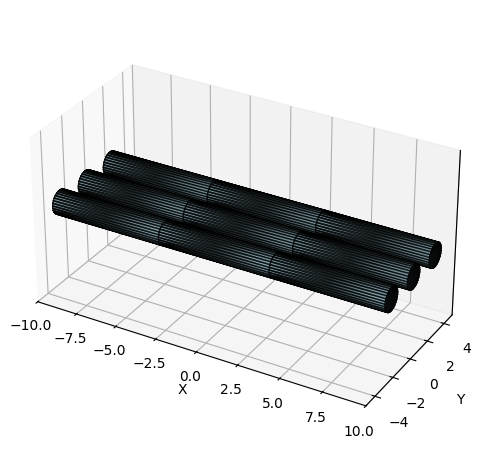

In [49]:
plot_mesh(mesh, [Lx, Ly, Lz], figsize=(8, 5))

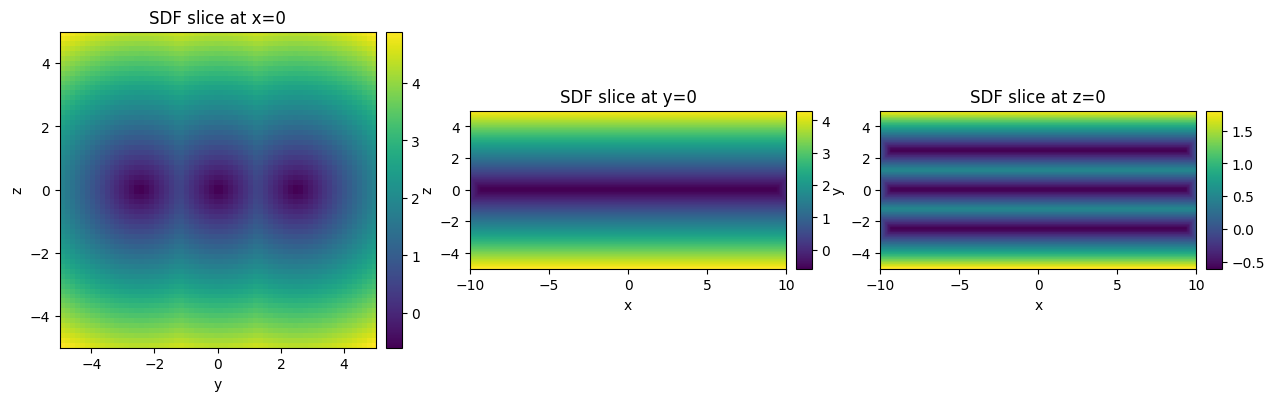

In [50]:
plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

To generate a smooth density field from the SDF field, we define a specific function that uses a sigmoid internally.

rho min: 5.256046708979056e-09, rho max: 0.9493274092674255


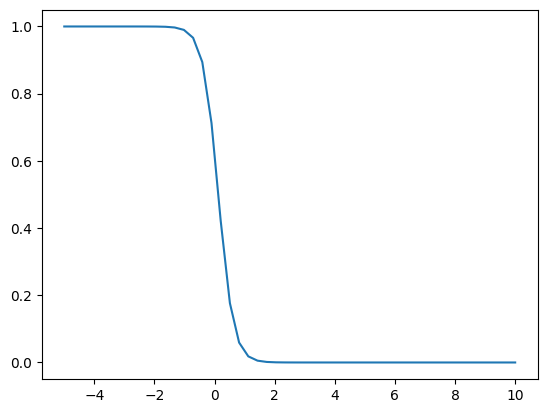

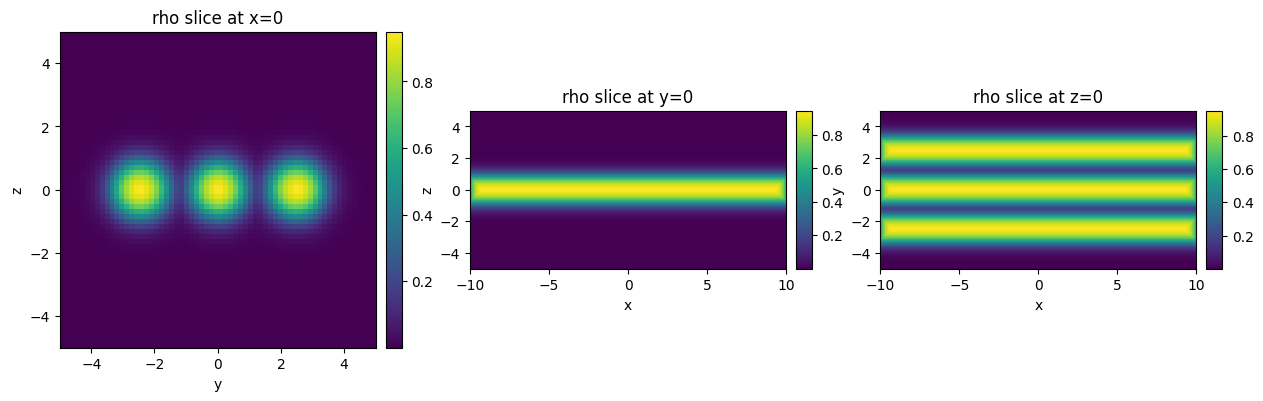

In [51]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 4
rho_offset = 0.5
# plot the functions
sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)

rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.625, max: 2.5


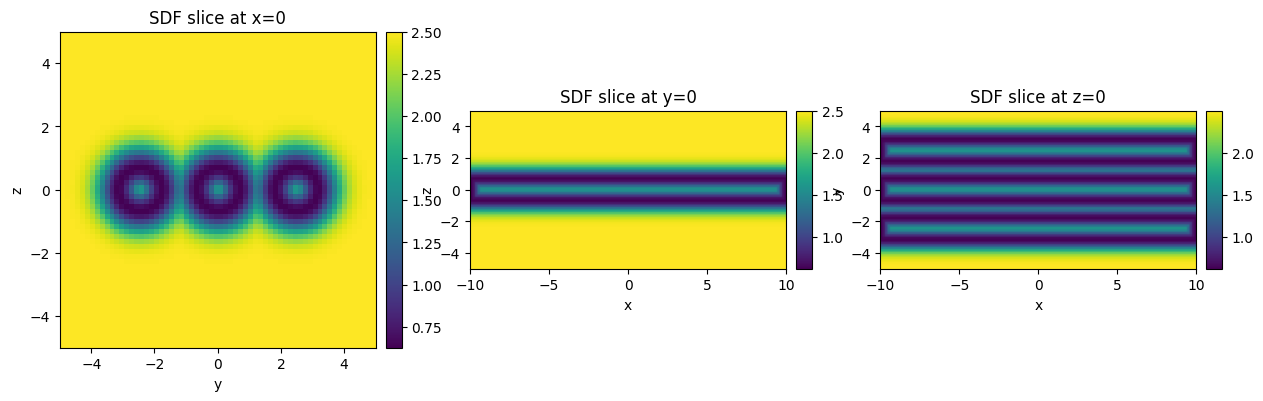

In [52]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 32
sizing_max = Lx / 8
sizing_scale = 2.0
sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [74]:
hex_tess = Tesseract.from_tesseract_api("hex_mesh/tesseract_api.py")


In [75]:
max_points = 30000
max_cells = 30000

mesher_out = apply_tesseract(
    hex_tess,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,
        "field_values": rho,
        "max_subdivision_levels": 3,
        "max_points": max_points,
        "max_cells": max_cells,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

hex_mesh = mesher_out["mesh"]

print(jnp.max(mesher_out["mesh_cell_values"]))
print(mesher_out["mesh_cell_values"].shape)

Done building mesh
Mesh points: 10231, Mesh faces: 7952
0.91622925
(30000,)


In [89]:
primals, vjp_fun = jax.vjp(
    lambda rho_: apply_tesseract(
        hex_tess,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,
            "field_values": rho_,
            "max_subdivision_levels": 3,
            "max_points": max_points,
            "max_cells": max_cells,
        },  
    )["mesh_cell_values"],
    rho)

cotan_prev = jnp.ones_like(mesher_out["mesh_cell_values"])
# lets add some sine fluctuations to the cotan
cotan_prev += 0.1 * jnp.sin(0.001 * jnp.arange(cotan_prev.size))
cotan = vjp_fun(cotan_prev)[0]

Done building mesh


We can look at the density values and the hex mesh cell center positions using a 3D scatter plot.

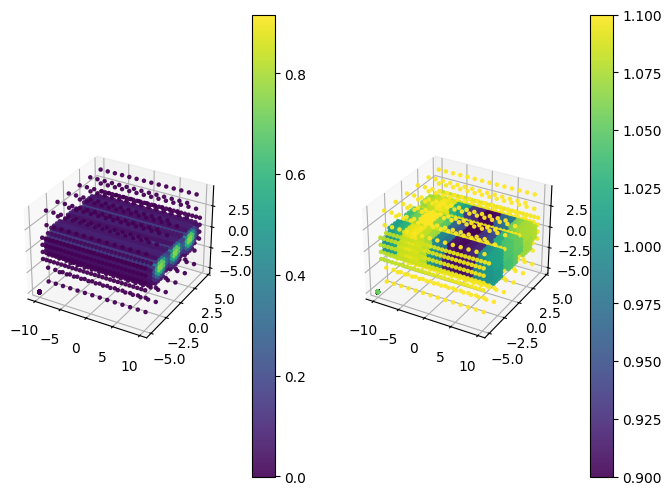

In [92]:
# lets make a scatter plot of the mesh cell values as colors
fig, axs = plt.subplots(1, 2, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = rho.flatten()
scat = axs[0].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=mesher_out["mesh_cell_values"],
    s=5,
    alpha=0.9,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=axs[0], pad=0.1)


# and the otan_prev values
scat2 = axs[1].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=cotan_prev,
    s=5,
    alpha=0.9,
    cmap="viridis",
)
# colorbar
cbar2 = plt.colorbar(scat2, ax=axs[1], pad=0.1)


### Vector-Jacobian Product (VJP)

Function: $f: \mathbb{R}^N \to \mathbb{R}^M$

---

**FORWARD PASS (Primal)**

$$x \in \mathbb{R}^N \quad \xrightarrow{\quad f \quad} \quad y \in \mathbb{R}^M$$

<div style="text-align: center; color: gray; font-size: 0.9em;">
(N-dimensional input) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (M-dimensional output)
</div>

---

**BACKWARD PASS (VJP)**

$$\frac{\partial L}{\partial x} \in \mathbb{R}^N \quad \xleftarrow{\quad \text{vjp} \quad} \quad \bar{v} \in \mathbb{R}^M$$

<div style="text-align: center; color: gray; font-size: 0.9em;">
(N-dimensional gradient) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (M-dimensional cotangent)
</div>

<div style="text-align: center; margin-top: 10px;">
↑<br>
cotangent vector<br>
<span style="color: red; font-weight: bold;">same shape as output $y$!</span>
</div>

---

**Key Insight:**

> **Cotangent $\bar{v}$ lives in output space $\mathbb{R}^M$**  
> **Result $\frac{\partial L}{\partial x}$ lives in input space $\mathbb{R}^N$**


Text(0, 0.5, 'Y')

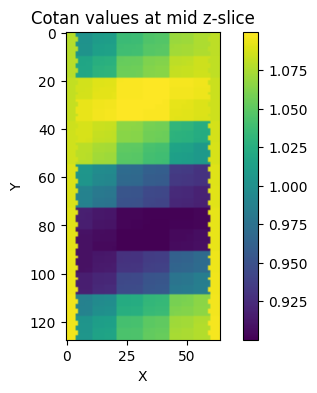

In [93]:
# we can also look at the cotan values after the hex mesher using a imshow
plt.figure(figsize=(6, 4))
plt.imshow(cotan.reshape((Nx, Ny, Nz))[:, :, Nz // 2], cmap="viridis")
plt.colorbar()
plt.title("Cotan values at mid z-slice")
plt.xlabel("X")
plt.ylabel("Y")

## Boundary Conditions

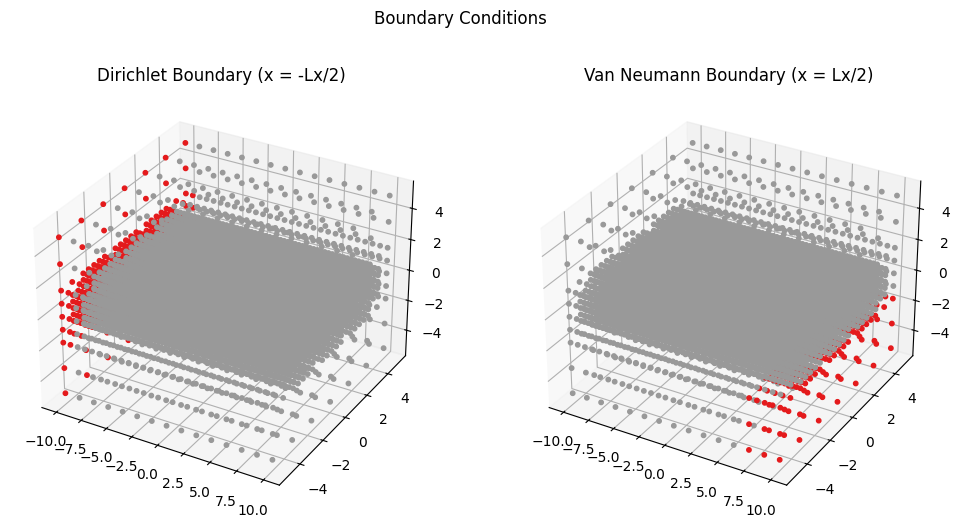

In [94]:
# Lets setup the boundary conditions


def get_boundary_masks(
    mesh: dict, Lx: float, Lz: float
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        von_neumannn_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 20
    von_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 3),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 3),
    )

    return dirichlet_mask, von_neumann_mask


dirichlet_mask, von_neumann_mask = get_boundary_masks(hex_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
pts = hex_mesh["points"][: hex_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: hex_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(von_neumann_mask[: hex_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
von_neumann_mask = von_neumann_mask.astype(jnp.int32)

## Finite Element Analysis

In [95]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": hex_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "von_neumann_mask": von_neumann_mask,
        "von_neumann_values": jnp.array([[0.0, 0.0, 1.0]]) / jnp.sum(von_neumann_mask),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[01-27 12:34:02][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-27 12:34:02][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[01-27 12:34:02][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[01-27 12:34:03][DEBUG] jax_fem: Done pre-computations, took 0.6015386581420898 [s]
[01-27 12:34:03][INFO] jax_fem: Solving a problem with 7952 cells, 10231x3 = 30693 dofs.
[01-27 12:34:03][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[01-27 12:34:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-27 12:34:04][DEBUG] jax_fem: Start timing
[01-27 12:34:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


JaxRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/asyncio/base_events.py", line 683, in run_forever
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/asyncio/events.py", line 89, in _run
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 519, in dispatch_queue
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 508, in process_one
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 368, in execute_request
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 455, in do_execute
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 577, in run_cell
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
  File "/tmp/ipykernel_11780/1732483408.py", line 1, in <module>
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 384, in apply_tesseract
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/core.py", line 1189, in process_primitive
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/dispatch.py", line 92, in apply_primitive
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 195, in reraise_with_filtered_traceback
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/pjit.py", line 264, in cache_miss
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/pjit.py", line 146, in _python_pjit_helper
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/pjit.py", line 1642, in _pjit_call_impl_python
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/profiler.py", line 359, in wrapper
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/interpreters/pxla.py", line 1371, in __call__
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/callback.py", line 784, in _wrapped_callback
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 208, in _dispatch
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/tesseract_jax/tesseract_compat.py", line 160, in apply
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 35, in wrapper
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 325, in apply
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 671, in run_tesseract
RuntimeError: Traceback (most recent call last):
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 664, in run_tesseract
    result = self._endpoints[endpoint](parsed_payload)
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/tesseract_core/runtime/core.py", line 155, in apply
    out = api_module.apply(payload.inputs)
  File "/home/ar/tesseract-core/demo/_showcase/ansys-shapeopt/jax_fem/tesseract_api.py", line 318, in apply
    return apply_fn(inputs.model_dump())
  File "/home/ar/tesseract-core/demo/_showcase/ansys-shapeopt/jax_fem/tesseract_api.py", line 305, in apply_fn
    sol_list = fwd_pred(rho)
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 195, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/custom_derivatives.py", line 749, in __call__
    out_flat = custom_vjp_call_p.bind(flat_fun, flat_fwd, flat_bwd,
                                      *args_flat, out_trees=out_trees,
                                      symbolic_zeros=self.symbolic_zeros)
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/custom_derivatives.py", line 1001, in bind
    return self._true_bind(*args, **params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
    return self.bind_with_trace(prev_trace, args, params)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/custom_derivatives.py", line 1005, in bind_with_trace
    return trace.process_custom_vjp_call(self, fun, fwd, bwd, tracers, **params)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/core.py", line 1210, in process_custom_vjp_call
    return fun.call_wrapped(*tracers)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
    return self.f_transformed(*args, **kwargs)
           ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/custom_derivatives.py", line 87, in _flatten_fun_nokwargs
    ans = f(*py_args)
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/custom_derivatives.py", line 759, in _check_primal_refs
    out = f(*args)
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
    ans = _fun(*args, **kwargs)
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax_fem/solver.py", line 860, in fwd_pred
    sol_list = solver(problem, solver_options)
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax_fem/solver.py", line 401, in solver
    res_vec, A = newton_update_helper(dofs)
                 ~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax_fem/solver.py", line 391, in newton_update_helper
    res_list = problem.newton_update(sol_list)
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax_fem/problem.py", line 420, in newton_update
    return self.compute_newton_vars(sol_list, self.internal_vars, self.internal_vars_surfaces)
           ~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax_fem/problem.py", line 406, in compute_newton_vars
    weak_form_flat, cells_jac_flat = self.split_and_compute_cell(cells_sol_flat, onp, True, internal_vars)
                                     ~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax_fem/utils.py", line 82, in timeit_wrapper
    result = func(*args, **kwargs)
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax_fem/problem.py", line 328, in split_and_compute_cell
    input_col = jax.tree_map(lambda x: x[i * batch_size:(i + 1) * batch_size], input_collection)
                ^^^^^^^^^^^^
  File "/home/ar/miniconda3/envs/optim/lib/python3.13/site-packages/jax/_src/deprecations.py", line 54, in getattr
    raise AttributeError(message)
AttributeError: jax.tree_map was removed in JAX v0.6.0: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).

Error running Tesseract API apply: jax.tree_map was removed in JAX v0.6.0: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version). (see above for full traceback)

In [ ]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [15]:
max_points = 15000
max_cells = 15000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        hex_tess,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho_grid,
            "max_subdivision_levels": 2,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, von_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    von_neumann_mask = jax.lax.stop_gradient(von_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    von_neumann_values = jnp.array([[0.0, 0.0, 1.0]]) / jnp.sum(von_neumann_mask)

    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "von_neumann_mask": von_neumann_mask,
            "von_neumann_values": von_neumann_values,
        },
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }


grad_fn = jax.value_and_grad(loss, has_aux=True)

In [17]:
def optimize(
    diffable_params: jnp.ndarray,
    iterations: int = 20,
) -> tuple[list, list, list]:
    """Optimize a design defined by parameters."""
    params = diffable_params.copy()
    loss_hist = []
    params_hist = []
    aux_hist = []

    optmizer = optax.adam(learning_rate=0.02)
    opt_state = optmizer.init(params)

    for i in range(iterations):
        (loss_value, aux), grads = grad_fn(params, iteration=i)

        grads = grads / jnp.max(grads)
        updates, opt_state = optmizer.update(
            grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
        )
        params = optax.apply_updates(params, updates)
        params = params.at[::3].set(initial_params.at[::3].get())

        loss_hist.append(loss_value)
        params_hist.append(params)
        aux_hist.append(aux)

        print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

    return loss_hist, params_hist, aux_hist

We can now run an optmization on the ranomly initialized geometry. The main bottleneck of this pipeline is the SDF compuations which has signifcant overhead slowing this optimization down. Exeucting this cell can take up to an hour.

In [18]:
loss_hist, params_hist, aux_hist = optimize(initial_params, iterations=16)

Iteration 1, Loss: 0.3303
Iteration 2, Loss: 0.3271
Iteration 3, Loss: 0.2051
Iteration 4, Loss: 0.1626
Iteration 5, Loss: 0.1593
Iteration 6, Loss: 0.1519
Iteration 7, Loss: 0.1390
Iteration 8, Loss: 0.1253
Iteration 9, Loss: 0.1112
Iteration 10, Loss: 0.0982
Iteration 11, Loss: 0.0869
Iteration 12, Loss: 0.0773
Iteration 13, Loss: 0.0689
Iteration 14, Loss: 0.0614
Iteration 15, Loss: 0.0556
Iteration 16, Loss: 0.0508


Text(0.5, 1.0, 'Compliance over Optimization')

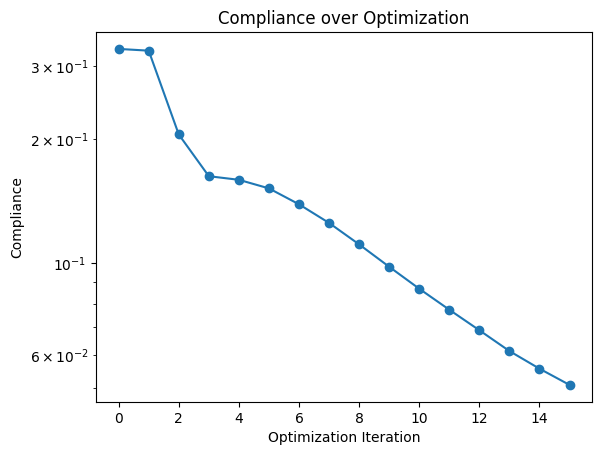

In [19]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

### Optimization Postprocess

In order to visualize the optmization, we generate a gif showing the evolution of the surface mesh.

In [20]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(
        aux["surface_mesh"],
        save_path=f"tmp_img/mesh_optim_{i:03d}.png",
        bounds=[Lx, Ly, Lz],
    )

images = []

for i in range(len(aux_hist)):
    filename = f"tmp_img/mesh_optim_{i:03d}.png"
    images.append(imageio.imread(filename))
    print(f"Added {filename} to gif.")
# make sure the gif repeats forever
imageio.mimsave("imgs/mesh_optim.gif", images, fps=10, loop=0)

/tmp/ipykernel_71070/1108791225.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Added tmp_img/mesh_optim_000.png to gif.
Added tmp_img/mesh_optim_001.png to gif.
Added tmp_img/mesh_optim_002.png to gif.
Added tmp_img/mesh_optim_003.png to gif.
Added tmp_img/mesh_optim_004.png to gif.
Added tmp_img/mesh_optim_005.png to gif.
Added tmp_img/mesh_optim_006.png to gif.
Added tmp_img/mesh_optim_007.png to gif.
Added tmp_img/mesh_optim_008.png to gif.
Added tmp_img/mesh_optim_009.png to gif.
Added tmp_img/mesh_optim_010.png to gif.
Added tmp_img/mesh_optim_011.png to gif.
Added tmp_img/mesh_optim_012.png to gif.
Added tmp_img/mesh_optim_013.png to gif.
Added tmp_img/mesh_optim_014.png to gif.
Added tmp_img/mesh_optim_015.png to gif.


![Workflow](imgs/mesh_optim.gif)